In [198]:
import pandas as pd
import os
import xarray as xr
from tqdm import tqdm
import altair as alt
import numpy as np

In [2]:
# download dir
avp_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/"
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"

ftp_url = 'ftp1.esrl.noaa.gov'
# Avery Picnic product
avp_url = f'Observations/Campaigns/SPLASH/asfs50/2_level_ingest/'
# Kettle Ponds product
kps_url = f'Observations/Campaigns/SPLASH/asfs30/2_level_ingest/'

In [3]:

# Get the list of files in the directory
file_list = os.listdir(kps_download_dir)

file_list = [f for f in file_list if 'sledmet.asfs30.level2.0.1min.' in f]

# Sort the file list
file_list.sort()

In [4]:
ds = xr.open_dataset(os.path.join(kps_download_dir, file_list[0]))
ds['h2o_licor'].plot

In [5]:
# Create an empty list to store the dataarrays
mixingratio_dataarray_list = []

abshum_dataarray_list = []

# Iterate over each file with tqdm
for file_name in tqdm(file_list):
    # Open the file using xarray
    dataset = xr.open_dataset(os.path.join(kps_download_dir, file_name))
    
    # Extract the dataarray for the variable 'mixing_ratio', Add the dataarray to the list
    mixingratio_dataarray_list.append(dataset['mixing_ratio'])
    abshum_dataarray_list.append(dataset['h2o_licor'])

100%|██████████| 646/646 [00:51<00:00, 12.44it/s]


In [6]:
from sublimpy import utils

In [7]:
mixingratio_ds = xr.concat(mixingratio_dataarray_list, dim='time')
mixingratio_ds = utils.modify_xarray_timezone(mixingratio_ds, 'UTC', 'US/Mountain')
abshum_ds = xr.concat(abshum_dataarray_list, dim='time')
abshum_ds = utils.modify_xarray_timezone(abshum_ds, 'UTC', 'US/Mountain')

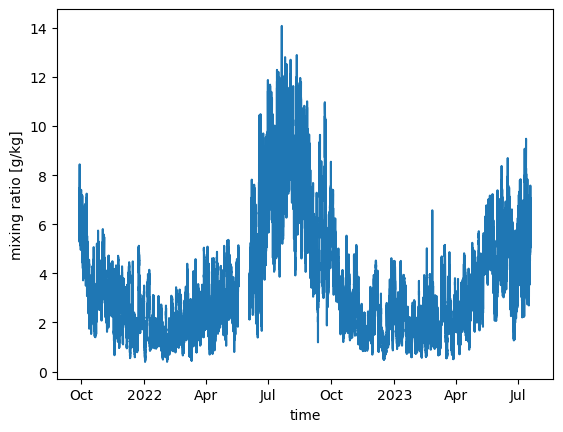

In [8]:
mixingratio_ds.plot()

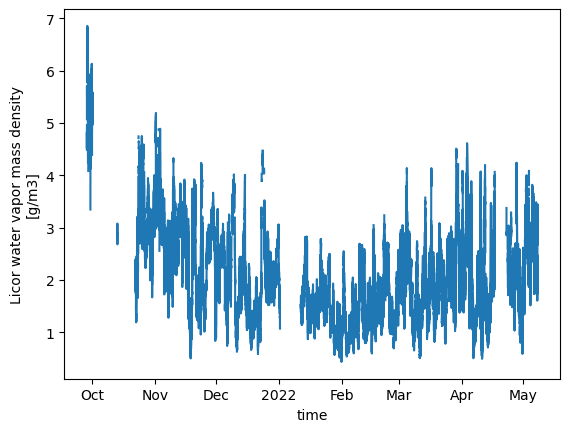

In [9]:
abshum_ds.plot()

In [10]:
heights = [1,3,10]
HORIZ_GRID_SPACING = 50
VERT_GRID_SPACING = 20
start_date = '20221101'
end_date = '20230619'
    # streamwise-coords
# tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet")
    # slope-adjusted earthwise-coords
# tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit.parquet")
    # sonic coords
tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")

tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')

In [11]:
tidy_df = tidy_df.set_index('time').sort_index().reset_index()

## Compare IRGA and Hygrometer measurements

In [44]:
comparison_df = pd.concat([
    (1000*tidy_df[tidy_df.measurement=='specific humidity'].set_index(['time','height','tower', 'measurement'])),
    tidy_df[tidy_df.measurement=='air density'].set_index(['time','height','tower', 'measurement']),
    tidy_df[tidy_df.measurement=='Water vapor density'].set_index(['time','height','tower', 'measurement'])
])[['value']]
comparison_df = comparison_df.reset_index().pivot_table(values='value', columns='measurement', index=['time','height','tower'])
comparison_df ['Water vapor density (hygr)'] = comparison_df['air density'] * comparison_df['specific humidity']
comparison_df = comparison_df.rename(columns={'Water vapor density': 'Water vapor density (irga)'})
comparison_df

measurement                       Water vapor density (irga)  air density  \
time                height tower                                            
2022-10-31 18:00:00 0.0    c                             NaN     0.929379   
                           d                             NaN     0.921632   
                    1.0    c                        2.505856     0.916267   
                           d                        3.119937          NaN   
                           ue                       2.816845          NaN   
...                                                      ...          ...   
2023-06-19 17:30:00 16.0   c                             NaN     0.858220   
                    17.0   c                             NaN     0.858006   
                    18.0   c                             NaN     0.857962   
                    19.0   c                             NaN     0.858107   
                    20.0   c                        1.824064     0.857857   

measurement                       specific humidity  \
time                height tower                      
2022-10-31 18:00:00 0.0    c               3.895127   
                           d                    NaN   
                    1.0    c               2.983229   
                           d                    NaN   
                           ue                   NaN   
...                                             ...   
2023-06-19 17:30:00 16.0   c               3.041327   
                    17.0   c               2.999553   
                    18.0   c               2.988210   
                    19.0   c               2.995862   
                    20.0   c               2.979198   

measurement                       Water vapor density (hygr)  
time                height tower                              
2022-10-31 18:00:00 0.0    c                        3.620051  
                           d                             NaN  
                    1.0    c                        2.733436  
                           d                             NaN  
                           ue                            NaN  
...                                                      ...  
2023-06-19 17:30:00 16.0   c                        2.610127  
                    17.0   c                        2.573635  
                    18.0   c                        2.563771  
                    19.0   c                        2.570770  
                    20.0   c                        2.555726  

[311246 rows x 4 columns]

In [52]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [232]:
import math 

src = comparison_df.loc[:,5,'c'].reset_index()
# max_val = math.ceil(
#     src[['Water vapor density (hygr)', 'Water vapor density (irga)']].dropna().values.max()
# )
max_val = 7
line = pd.DataFrame({
    'Goals Conceded': [0, max_val],
    'Goals': [0, max_val],
})

arr = np.array([0, max_val] * (len(src) // 2))
if len(arr) < len(src):
    src['one'] = list(arr) + [0]
    src['onetoone'] = list(arr) + [0]
else:
    src['one'] = list(arr)
    src['onetoone'] = list(arr)

line_plot = alt.Chart().mark_line(color= 'grey').encode(
    alt.X('one', title=''),
    alt.Y('onetoone', title='')
)
scatter_plot = alt.Chart().mark_rect().encode(
    alt.X('Water vapor density (hygr):Q').scale(domain = [0, max_val], clamp=True).bin(maxbins=75).axis(values=[0,1,2,3,4,5,6,7]).title('Water vapor density (hygr)'),
    alt.Y('Water vapor density (irga):Q').scale(domain = [0, max_val], clamp=True).bin(maxbins=75).axis(values=[0,1,2,3,4,5,6,7]).title('Water vapor density (irga)'),
    alt.Color('count()'),
).properties(width=200, height=200)

src['diff'] = (src.set_index('time')['Water vapor density (irga)'] - src.set_index('time')['Water vapor density (hygr)']).values

from sklearn.metrics import r2_score
meanerror_by_month = round(src.groupby(src.time.dt.month).mean().drop(columns='time')['diff'], 3)
r2_by_month = round(src.groupby(src.time.dt.month)[[
    'Water vapor density (hygr)', 'Water vapor density (irga)'
]].apply(
    lambda df: r2_score(df.dropna()['Water vapor density (hygr)'], df.dropna()['Water vapor density (irga)'])
), 3)

def r2_plot(month, title):
    return alt.layer(
        scatter_plot,
        line_plot,
        data=src[(src.time.dt.month == month)]
    ).properties(title=f'{title} (ME: {meanerror_by_month.loc[month]}, R2: {r2_by_month.loc[month]})')

(
    r2_plot(11, 'Nov.') | r2_plot(12, 'Dec.') | r2_plot(1, 'Jan.') | r2_plot(2, 'Feb.') | r2_plot(3, 'Mar.') | r2_plot(4, 'Apr.') | r2_plot(5, 'May') | r2_plot(6, 'June')
) & (
    alt.layer(
        alt.Chart().mark_rule().transform_calculate(
            y = '0'
        ).mark_rule().encode(alt.Y('y:Q')),
        alt.Chart().mark_line().encode(
            alt.X('hoursminutes(time):T'),
            alt.Y('mean(diff):Q').title('Mean difference (irga - hygr) (g/m^3)'),
        ),
        data = src[(src.time.dt.month != 10)]
    ).properties(width=230, height=230).facet(
        column=alt.Column('month(time):T', sort=[11,12,1,2,3,4,5,6])
    )
)

alt.VConcatChart(...)

## Calibrate gas analyzer measurements

We calibrate by assuming that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

### With seasonal mean

In [12]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [13]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [14]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

,variable,tower,height,value,truth,offset
0,h2o_10m_c,c,10.0,2.524960,2.487768,0.037192
1,h2o_10m_d,d,10.0,1.777380,2.487768,-0.710388
2,h2o_10m_ue,ue,10.0,1.466664,2.487768,-1.021105
3,h2o_10m_uw,uw,10.0,2.096750,2.487768,-0.391018
4,h2o_15m_c,c,15.0,2.291071,2.466526,-0.175455
5,h2o_1m_c,c,1.0,2.839837,2.644184,0.195654
6,h2o_1m_d,d,1.0,2.036135,2.644184,-0.608049
7,h2o_1m_ue,ue,1.0,2.150419,2.644184,-0.493765
8,h2o_1m_uw,uw,1.0,2.426378,2.644184,-0.217805
9,h2o_20m_c,c,20.0,1.256475,2.452869,-1.196394


Update dataset with corrections

In [15]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
src

,time,variable,value,height,tower,measurement
27,2022-10-31 18:00:00,h2o_10m_ue,1.805038,10.0,ue,Water vapor density
47,2022-10-31 18:00:00,h2o_1m_ue,2.323081,1.0,ue,Water vapor density
89,2022-10-31 18:00:00,h2o_3m_c,2.547044,3.0,c,Water vapor density
148,2022-10-31 18:00:00,h2o_1m_c,2.701510,1.0,c,Water vapor density
192,2022-10-31 18:00:00,h2o_10m_c,2.727012,10.0,c,Water vapor density
...,...,...,...,...,...,...
9590654,2023-06-19 17:30:00,h2o_3m_d,3.101750,3.0,d,Water vapor density
9590676,2023-06-19 17:30:00,h2o_10m_d,2.669686,10.0,d,Water vapor density
9590686,2023-06-19 17:30:00,h2o_3m_c,2.461334,3.0,c,Water vapor density
9590788,2023-06-19 17:30:00,h2o_1m_uw,3.362670,1.0,uw,Water vapor density


In [16]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

alt.LayerChart(...)

In [17]:


alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_32899/1085128452.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


alt.Chart(...)

In [18]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [19]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

alt.LayerChart(...)

In [20]:
# this is created in the flux_divergence_3d_numerical_pawu.ipynb notebook
src = pd.read_csv('irga_mixingratio_estimates.csv')
src.time = pd.to_datetime(src.time)
from sublimpy import utils
src.value = src.value*1000
src = src.set_index('time')

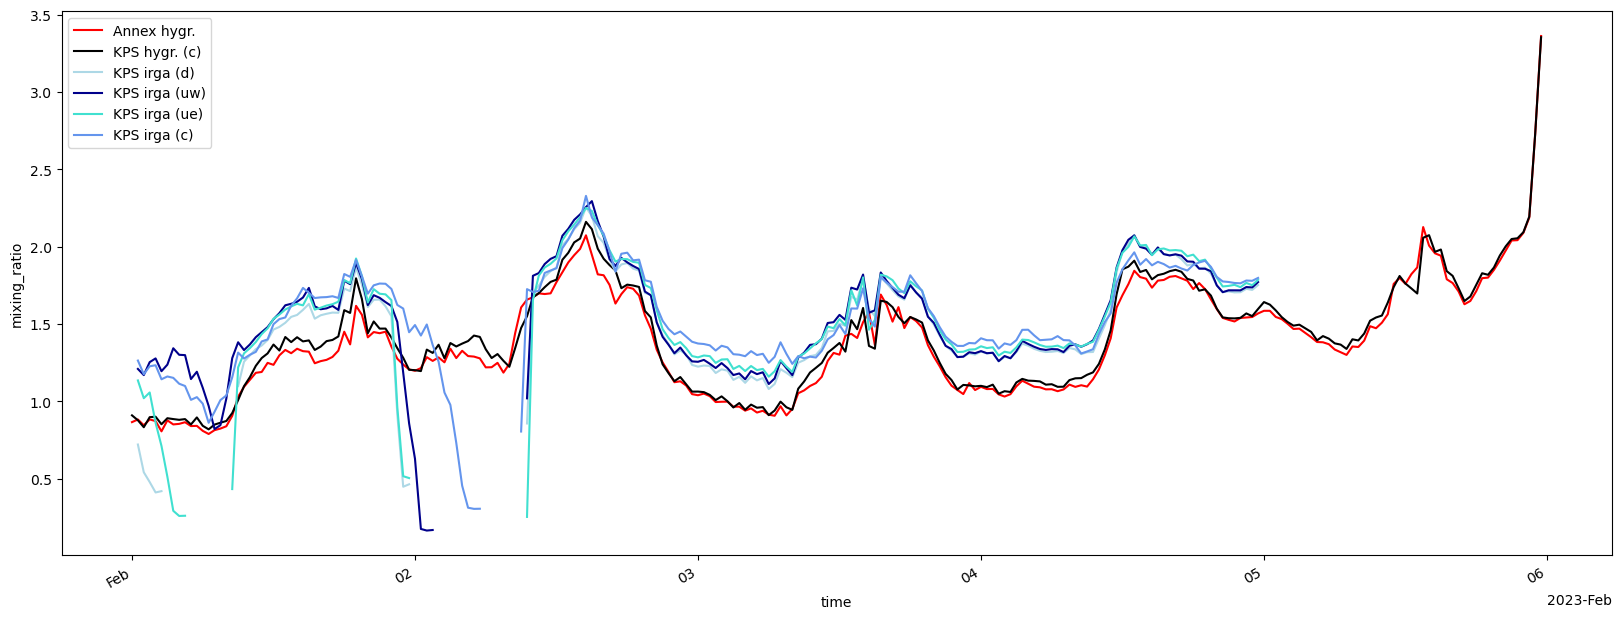

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,8))
mixingratio_ds.to_dataframe().sort_index().to_xarray().sel(time=slice('20230201', '20230205')).resample(time='30min').mean()['mixing_ratio'].plot(ax=ax, label='Annex hygr.', color='red')
(tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc['20230201': '20230205']['value']*1000).plot(ax=ax, label='KPS hygr. (c)', color='black')
src.query("tower == 'd'")['value'].plot(ax=ax, label='KPS irga (d)', color='lightblue')
src.query("tower == 'uw'")['value'].plot(ax=ax, label='KPS irga (uw)', color='darkblue')
src.query("tower == 'ue'")['value'].plot(ax=ax, label='KPS irga (ue)', color='turquoise')
src.query("tower == 'c'")['value'].plot(ax=ax, label='KPS irga (c)', color='cornflowerblue')
plt.legend()

Text(0, 0.5, 'mixing ration [g/kg]')

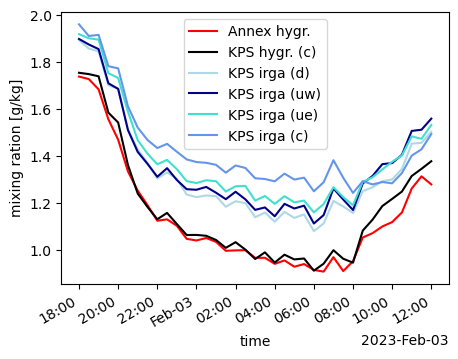

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,4))
mixingratio_ds.to_dataframe().sort_index().to_xarray().sel(time=slice('20230202 1800','20230203 1200')).resample(time='30min').mean()['mixing_ratio'].plot(ax=ax, label='Annex hygr.', color='red')
(tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc['20230202 1800':'20230203 1200']['value']*1000).plot(ax=ax, label='KPS hygr. (c)', color='black')
src.sort_index().loc['20230202 1800':'20230203 1200'].query("tower == 'd'")['value'].plot(ax=ax, label='KPS irga (d)', color='lightblue')
src.sort_index().loc['20230202 1800':'20230203 1200'].query("tower == 'uw'")['value'].plot(ax=ax, label='KPS irga (uw)', color='darkblue')
src.sort_index().loc['20230202 1800':'20230203 1200'].query("tower == 'ue'")['value'].plot(ax=ax, label='KPS irga (ue)', color='turquoise')
src.sort_index().loc['20230202 1800':'20230203 1200'].query("tower == 'c'")['value'].plot(ax=ax, label='KPS irga (c)', color='cornflowerblue')
plt.legend()
plt.ylabel('mixing ration [g/kg]')

In [23]:
# this is created in the flux_divergence_3d_numerical_pawu.ipynb notebook
src = pd.read_csv('irga_mixingratio_estimates_2.csv')
src.time = pd.to_datetime(src.time)
from sublimpy import utils
src.value = src.value*1000
src = src.set_index('time')

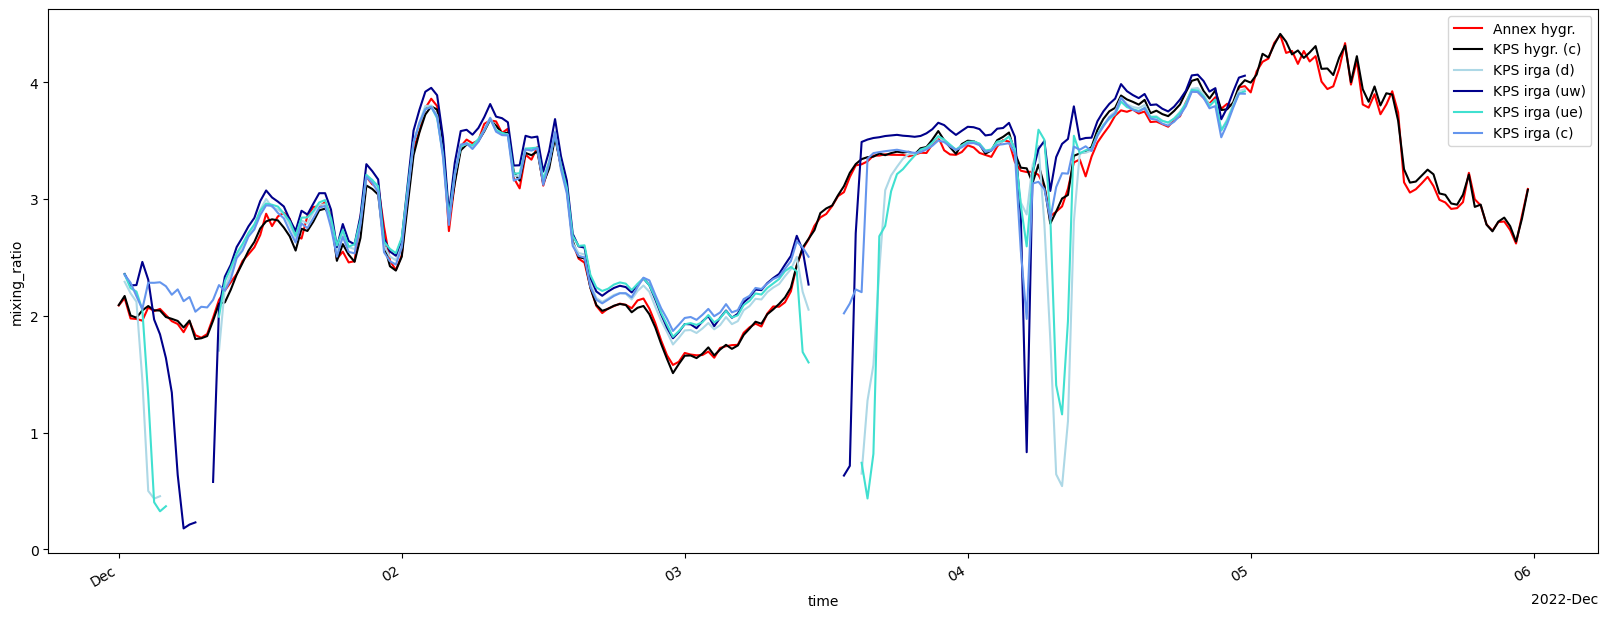

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,8))
mixingratio_ds.to_dataframe().sort_index().to_xarray().sel(time=slice('20221201', '20221205')).resample(time='30min').mean()['mixing_ratio'].plot(ax=ax, label='Annex hygr.', color='red')
(tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc['20221201': '20221205']['value']*1000).plot(ax=ax, label='KPS hygr. (c)', color='black')
src.query("tower == 'd'")['value'].plot(ax=ax, label='KPS irga (d)', color='lightblue')
src.query("tower == 'uw'")['value'].plot(ax=ax, label='KPS irga (uw)', color='darkblue')
src.query("tower == 'ue'")['value'].plot(ax=ax, label='KPS irga (ue)', color='turquoise')
src.query("tower == 'c'")['value'].plot(ax=ax, label='KPS irga (c)', color='cornflowerblue')
plt.legend()

# Scaling analysis (for 1D advection)

## Horizontal advection using KPS and Annex hygrometer measurements

In [ ]:
# combine mixing ration measurements from the two sites
kpsannex_mixingratio_measurements = mixingratio_ds.sortby('time').sel(
    time=slice('20221101', '20230620')
).resample(time='30min').mean().rename('annex').to_dataframe() / 1000
kps_mixingratio_measurements = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc[
    '20221101': '20230620'
]['value'].rename('kps')
kps_vs_annex_df = kpsannex_mixingratio_measurements.join(kps_mixingratio_measurements)

# # Add wind dir variable
kps_vs_annex_df = kps_vs_annex_df.join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('dir_10m_c')
)

# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
kps_vs_annex_df = kps_vs_annex_df[
    ((kps_vs_annex_df.dir_10m_c >= 100) & (kps_vs_annex_df.dir_10m_c <= 140))
    |
    ((kps_vs_annex_df.dir_10m_c >= 300) & (kps_vs_annex_df.dir_10m_c <= 340))
]

# label each timestamp up or downvalley
kps_vs_annex_df['direction'] = kps_vs_annex_df['dir_10m_c'].apply(lambda x: 'down' if 300 <= x <= 340 else 'up')

# # Calculate deltas. During downvalley winds, ds = annex - kps. During up valley winds, ds = kps - annex
kps_vs_annex_df['ds'] = kps_vs_annex_df.apply(
    lambda row: row['annex'] - row['kps'] if row['direction'] == 'down' else row['kps'] - row['annex'],
    axis=1
)

kps_vs_annex_df['dx'] = 400
kps_vs_annex_df['ds/dx'] = kps_vs_annex_df['ds'] / kps_vs_annex_df['dx']

# # Add other variables from KPS
kps_vs_annex_df = kps_vs_annex_df.join(
    tidy_df.query("variable == 'spd_10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('u')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
)

kps_vs_annex_df.dropna()

$$\large \overline{u} \space \overline{\rho} \frac{\partial s}{\partial x}$$

In [ ]:
kps_vs_annex_df['lateral_advection'] = kps_vs_annex_df['u'] * kps_vs_annex_df['rho'] * kps_vs_annex_df['ds/dx']

In [ ]:
kps_vs_annex_df['u'].mean(), kps_vs_annex_df['rho'].mean(), kps_vs_annex_df['ds/dx'].mean(), kps_vs_annex_df['lateral_advection'].mean()

In [ ]:
kps_vs_annex_df = kps_vs_annex_df.sort_index()

In [ ]:
src

In [ ]:
import altair as alt
src = kps_vs_annex_df.copy()
src = (src.assign(lateral_advection= 7*src.lateral_advection)).reset_index()
src = src.set_index('time').sort_index().loc['20230201':'20230206']
alt.Chart(
    src.reset_index()
).transform_fold(
    ['lateral_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').title('Water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(width = 800).configure_legend(orient='top', labelFontSize=16)

In [ ]:
alt.data_transformers.enable('json')

In [ ]:
import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_vs_annex_df.copy()
src = (src.assign(lateral_advection= 7*src.lateral_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['lateral_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)').scale(
        domain=[-0.001, 0.006]
    ),
    alt.Color('key:N'),
).properties(width = 200, height = 200).display(renderer='svg')

In [ ]:
import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_vs_annex_df.copy()
src = (src.assign(lateral_advection= 7*src.lateral_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['lateral_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N'),
    alt.Facet('month(time):T').sort(['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])
).properties(width = 200, height = 200)

Assume a 1D equation for advective divergence.

$\overline{u} \space \overline{\rho} \frac{\partial s}{\partial x}$

For the night of Feb 2nd approximately:
* a 0.2 difference in the mixing ratio ($s$) between the two sites ($\Delta s \approx 0.2$ g/kg $\approx 0.0002$ g/g)
* The sites are about 500 meters apart ($\Delta x \approx  500$ meters)
* Wind speed could be 1-2 meters ($\overline{u} \approx 1$)
* Density could be about 960 g/m $^3$

So our advective term might equal:

$1 (m/s) * 960 g/m^3 * 0.0002 / 500 m$

This results in about $0.0003$ g/m^3/s, or, multiplying by the height of our site to get a flux density, 7m, 0.002-0.003 g/m^2/s

## Vertical advection using KPS hygrometer measurements

In [ ]:
kps_mixingratio_measurements_3m = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc[
    '20221101': '20230620'
]['value'].rename('mixingratio_3m_c')
kps_mixingratio_measurements_10m = tidy_df.query("variable == 'mixingratio_10m_c'").set_index('time').loc[
    '20221101': '20230620'
]['value'].rename('mixingratio_10m_c')
kps_vert_df = pd.DataFrame(kps_mixingratio_measurements_3m).join(kps_mixingratio_measurements_10m)
kps_vert_df['ds'] = kps_vert_df['mixingratio_10m_c'] - kps_vert_df['mixingratio_3m_c']
kps_vert_df['dz'] = 7
kps_vert_df['ds/dz'] = kps_vert_df['ds'] / kps_vert_df['dz']

kps_vert_df = kps_vert_df.join(
    tidy_df.query("variable == 'w_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
)
kps_vert_df['vertical_advection'] =  kps_vert_df['w'] * kps_vert_df['rho'] * kps_vert_df['ds/dz']
kps_vert_df

In [ ]:
import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_vert_df.copy()
src = (src.assign(vertical_advection= 7*src.vertical_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['vertical_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)').scale(
        domain=[-0.001, 0.006]
    ),
    alt.Color('key:N'),
).properties(width = 200, height = 200).display(renderer='svg')

In [ ]:
import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_vert_df.copy()
src = (src.assign(vertical_advection= 7*src.vertical_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['vertical_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N'),
    alt.Facet('month(time):T').sort(['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])
).properties(width = 200, height = 200)

In [ ]:
alt.Chart(
    tidy_df[tidy_df.variable.isin([
        'w_2m_c', 'w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    ])]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Wind speed (m/s)'),
    alt.Color('height:O').scale(scheme='sinebow'),
    alt.Row('tower:N'),
    tooltip='height',
).properties(width = 200, height = 200, title='Vertical wind speed') | alt.Chart(
    tidy_df[tidy_df.variable.isin(['mixingratio_2m_c', 'mixingratio_3m_c', 'mixingratio_5m_c', 'mixingratio_10m_c', 'mixingratio_15m_c', 'mixingratio_20m_c',])]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor mixing ratio (g/g)').scale(zero=False),
    alt.Color('height:O'),
    tooltip='height',
).properties(width = 200, height = 200, title='Hygrometer mixing ratio') | alt.Chart(
    tidy_df[tidy_df.variable.isin(['h2o_2m_c', 'h2o_3m_c', 'h2o_5m_c', 'h2o_10m_c', 'h2o_15m_c', 'h2o_20m_c',])]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Absolute humidity (g/m^3)').scale(zero=False),
    alt.Color('height:O'),
    tooltip='height',
).properties(width = 200, height = 200, title='IRGA absolute humidity')

### Sophisticated method using interpolated fields

In [ ]:
w_values = tidy_df[tidy_df.variable.isin([
    'w_2m_c', 'w_3m_c', 'w_5m_c', 'w_10m_c'
])]
mixingratio_values = tidy_df[tidy_df.measurement == 'mixing ratio'].query("tower == 'c'").query("height <= 10")
dryairdensity_values = tidy_df[tidy_df.measurement == 'dry air density'].query("tower == 'c'").query("height <= 10")

In [ ]:
ts = "2023-02-02 14:30:00"
w = w_values[w_values.time == ts][['height', 'value']].set_index('height').rename(columns={'value': 'w'}) 
# add zero vertical velocity at 0 for w
w.loc[0] = 0
s = mixingratio_values[mixingratio_values.time == ts][['height', 'value']].set_index('height').rename(columns={'value': 's'})
rho = dryairdensity_values[dryairdensity_values.time == ts][['height', 'value']].set_index('height').rename(columns={'value': 'rho'})

In [ ]:
alt.Chart(s.reset_index()).mark_line(point=True).encode(
    alt.X('s:Q', sort='y'),
    alt.Y('height:Q')
).properties(width=100, height=200) | alt.Chart(w.reset_index()).mark_line(point=True).encode(
    alt.X('w:Q', sort='y'),
    alt.Y('height:Q')
).properties(width=100, height=200) | alt.Chart(rho.reset_index()).mark_line(point=True).encode(
    alt.X('rho:Q', sort='y'),
    alt.Y('height:Q')
).properties(width=100, height=200)

In [ ]:
# interpolate for values between 0 and 10 meters
w
s
rho

In [ ]:
w_interp = pd.DataFrame({
    'height': list(np.arange(0,11)),
    'w': np.interp(
        list(np.arange(0,11)),
        w.sort_index().index,
        w.sort_index()['w']
    )
})
s_interp = pd.DataFrame({
    'height': list(np.arange(0,11)),
    's': np.interp(
        list(np.arange(0,11)),
        s.sort_index().index,
        s.sort_index()['s']
    )
})
rho_interp = pd.DataFrame({
    'height': list(np.arange(0,11)),
    'rho': np.interp(
        list(np.arange(0,11)),
        rho.sort_index().index,
        rho.sort_index()['rho']
    )
})

In [ ]:
alt.Chart(s_interp.reset_index()).mark_line(point=True).encode(
    alt.X('s:Q', sort='y'),
    alt.Y('height:Q')
).properties(width=100, height=200) | alt.Chart(w_interp.reset_index()).mark_line(point=True).encode(
    alt.X('w:Q', sort='y'),
    alt.Y('height:Q')
).properties(width=100, height=200) | alt.Chart(rho_interp.reset_index()).mark_line(point=True).encode(
    alt.X('rho:Q', sort='y'),
    alt.Y('height:Q')
).properties(width=100, height=200)

In [ ]:
df = s_interp.set_index('height').join(
    w_interp.set_index('height')
).join(
    rho_interp.set_index('height')
)

In [ ]:
df

In [ ]:
(df['w']*df['rho']*np.gradient(df['s'], 1)).sum()

## Horizontal advection using KPS gas analyzer measurements

In [ ]:
import pandas as pd

In [ ]:
mixing_ratio_field_df = pd.read_pickle('mixing_ratio_field_df.pkl')
mixing_ratio_field_df


In [ ]:
# get mixing ratio measurements from the corner towers
upwind_s = 0.5*(mixing_ratio_field_df[3, 'ue', 'r'] + mixing_ratio_field_df[3, 'uw', 'r'])
upwind_s.name = 'upwind_s'
kps_df = pd.DataFrame(upwind_s)
kps_df['downwind_s'] = mixing_ratio_field_df[3, 'd', 'r']


# # Add wind dir variable
kps_df = kps_df.join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('dir_10m_c')
)

# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
kps_df = kps_df[
    ((kps_df.dir_10m_c >= 100) & (kps_df.dir_10m_c <= 140))
    |
    ((kps_df.dir_10m_c >= 300) & (kps_df.dir_10m_c <= 340))
]

# label each timestamp up or downvalley
kps_df['direction'] = kps_df['dir_10m_c'].apply(lambda x: 'down' if 300 <= x <= 340 else 'up')
# # Calculate deltas. During downvalley winds, ds = annex - kps. During up valley winds, ds = kps - annex
kps_df['ds'] = kps_df.apply(
    lambda row: row['downwind_s'] - row['upwind_s'] if row['direction'] == 'down' else row['upwind_s'] - row['downwind_s'],
    axis=1
)

kps_df['dx'] = 32
kps_df['ds/dx'] = kps_df['ds'] / kps_df['dx']
kps_df = kps_df.join(
    tidy_df.query("variable == 'u_3m_c'").set_index('time')['value'].rename('u')
)
kps_df = kps_df.join(
    1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time')['value'].rename('rho')
)
kps_df = kps_df.join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time')['value'].rename('w_h2o__3m_c')
)
kps_df['lateral_advection'] = kps_df['u'] * kps_df['rho'] * kps_df['ds/dx']
kps_df

In [ ]:

import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_df.copy()
src = (src.assign(lateral_advection= 7*src.lateral_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['lateral_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)'),
    alt.Color('key:N'),
).properties(width = 200, height = 200)

## Vertical advection using KPS gas analyzer measurements

In [ ]:
src3m = mixing_ratio_field_df[3, 'c', 'r'] 
src3m.name = 'mixing ratio 3m'
src10m = mixing_ratio_field_df[10, 'c', 'r']
src10m.name = 'mixing ratio 10m'
kps_vert_irga_df = pd.DataFrame(src3m).join(src10m)
kps_vert_irga_df['ds'] = kps_vert_irga_df['mixing ratio 10m'] - kps_vert_irga_df['mixing ratio 3m']
kps_vert_irga_df['dz'] = 7
kps_vert_irga_df['ds/dz'] = kps_vert_irga_df['ds'] / kps_vert_irga_df['dz']

kps_vert_irga_df = kps_vert_irga_df.join(
    tidy_df.query("variable == 'w_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')   
)
kps_vert_irga_df['vertical_advection'] =  kps_vert_irga_df['w'] * kps_vert_irga_df['rho'] * kps_vert_irga_df['ds/dz']

kps_vert_irga_df

In [ ]:
import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_vert_irga_df.copy()
src = (src.assign(vertical_advection= 7*src.vertical_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['vertical_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)').scale(
        domain=[-0.001, 0.006]
    ),
    alt.Color('key:N'),
).properties(width = 200, height = 200).display(renderer='svg')

# Combine results

In [ ]:
print(len(kps_vs_annex_df.dropna()))
print(len(kps_vert_df.dropna()))
print(len(kps_df.dropna()))

In [ ]:
src = kps_vs_annex_df[['lateral_advection']].rename(
        columns={'lateral_advection': 'kps-annex lateral advection'}
    ).join(
        kps_vert_df[['vertical_advection']].rename(
            columns={'vertical_advection': 'kps vertical advection'}
        )
    ).join(
        kps_df[['lateral_advection', 'w_h2o__3m_c']].rename(
            columns={'lateral_advection': 'kps lateral advection'}
        )
    )

src['kps-annex lateral advection'] = 7 * src['kps-annex lateral advection']
src['kps vertical advection'] = 7 * src['kps vertical advection']
src['kps lateral advection'] = 7 * src['kps lateral advection']

In [ ]:
(
    alt.Chart(
        src.reset_index()
    ).transform_fold([
        'kps vertical advection',
        'kps lateral advection',
        'w_h2o__3m_c',
    ]).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)'),
        alt.Color('key:N').sort(['w_h2o__3m_c', 'kps lateral advection', 'kps vertical advection'])
    ).properties(width=200, height=200) | alt.Chart(
        src.reset_index()
    ).transform_fold([
        'kps-annex lateral advection',
        'w_h2o__3m_c',
    ]).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)'),
        alt.Color('key:N').sort(['w_h2o__3m_c', 'kps-annex lateral advection'])
    ).properties(width=200, height=200)
).resolve_scale(y='shared', color='independent').configure_legend(orient='top', columns=1).display(renderer='svg')